# 🏦 Projet 12 — Détection automatique de faux billets
## Organisation nationale de lutte contre le faux-monnayage (ONCFM)

**Objectif** : Construire un algorithme capable de différencier automatiquement les vrais des faux billets
à partir de leurs caractéristiques géométriques.

**Données** : 1 500 billets (1 000 vrais, 500 faux) avec 6 dimensions géométriques.

**Modèles testés** : Régression logistique, K-Means, KNN, Random Forest.


## 1. Importation des bibliothèques et chargement des données


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Chargement du dataset
df = pd.read_csv('billets.csv', sep=';')
print(f"Dataset chargé : {df.shape[0]} billets, {df.shape[1]} colonnes")
df.head()

Dataset chargé : 1500 billets, 7 colonnes


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


## 2. Analyse descriptive des données

### 2.1 Répartition des billets (vrais / faux)


In [2]:
# Répartition vrais / faux
print(df['is_genuine'].value_counts())
print(f"\nRapport Vrais/Faux : {df['is_genuine'].sum()} / {(~df['is_genuine']).sum()}")


is_genuine
True     1000
False     500
Name: count, dtype: int64

Rapport Vrais/Faux : 1000 / 500


### 2.2 Statistiques descriptives par groupe


In [3]:
# Statistiques descriptives
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
df.groupby('is_genuine')[features].describe().round(3)


diagonal                                                           \
              count     mean    std     min     25%     50%      75%     max   
is_genuine                                                                     
False         500.0  171.901  0.307  171.04  171.69  171.91  172.092  173.01   
True         1000.0  171.987  0.300  171.04  171.79  171.99  172.200  172.92   

           height_left           ... margin_up        length                  \
                 count     mean  ...       75%   max   count     mean    std   
is_genuine                       ...                                           
False            500.0  104.190  ...     3.472  3.91   500.0  111.631  0.616   
True            1000.0  103.949  ...     3.180  3.74  1000.0  113.202  0.360   

                                                     
               min     25%      50%     75%     max  
is_genuine                                           
False       109.49  111.20  111.630  112.03  113.85  
True        111.76  112.95  113.205  113.46  114.44  

[2 rows x 48 columns]

### 2.3 Distributions des caractéristiques géométriques

Les histogrammes ci-dessous montrent la répartition de chaque dimension pour les vrais et faux billets.
On observe déjà une séparation claire sur plusieurs caractéristiques (notably `length`, `margin_low`, `margin_up`).


In [4]:
# Visualisation des distributions
# (Figure générée avec matplotlib - voir fig01)


### 2.4 Boxplots — Détection des outliers


In [5]:
# Boxplots par caractéristique


### 2.5 Scatter plots — Variables les plus discriminantes

Les couples `(length, margin_low)` et `(margin_up, height_left)` montrent une séparation visuelle claire
entre vrais et faux billets, confirmant leur pouvoir discriminant.


In [6]:
# Scatter plots des couples de variables clés


### 2.6 Matrice de corrélation

On vérifie les interdépendances entre les caractéristiques géométriques.


In [7]:
# Matrice de corrélation


## 3. Gestion des valeurs manquantes

Seule la variable `margin_low` possède des valeurs manquantes (37 sur 1500, soit 2.47%).
**Méthode choisie** : Imputation par la médiane **par groupe** (`is_genuine`).
Cette approche préserve la distribution caractéristique de chaque type de billet et évite
de biaiser les données en mêlant les statistiques des vrais et faux billets.


In [8]:
# Analyse des valeurs manquantes
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
pd.DataFrame({'Valeurs manquantes': missing, 'Pourcentage (%)': missing_pct})


,Valeurs manquantes,Pourcentage (%)
is_genuine,0,0.00
diagonal,0,0.00
height_left,0,0.00
height_right,0,0.00
margin_low,37,2.47
margin_up,0,0.00
length,0,0.00


In [9]:
# Imputation par médiane par groupe
df_clean = df.copy()
for label in [True, False]:
    mask = (df_clean['is_genuine'] == label) & (df_clean['margin_low'].isnull())
    median_val = df_clean.loc[df_clean['is_genuine'] == label, 'margin_low'].median()
    df_clean.loc[mask, 'margin_low'] = median_val
    print(f"  Groupe is_genuine={label} : {mask.sum()} valeurs imputées avec médiane = {median_val}")

print(f"\nValeurs manquantes après imputation : {df_clean.isnull().sum().sum()}")


  Groupe is_genuine=True : 29 valeurs imputées avec médiane = 4.11
  Groupe is_genuine=False : 8 valeurs imputées avec médiane = 5.19

Valeurs manquantes après imputation : 0


## 4. Séparation du dataset (Train / Test)

- **Ratio** : 70% entraînement / 30% test
- **Stratification** : On préserve la proportion de vrais/faux dans les deux ensembles
- **random_state=42** pour la reproductibilité


In [10]:
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df_clean[features]
y = df_clean['is_genuine'].astype(int)  # True=1 (Vrai), False=0 (Faux)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Ensemble d'entraînement : {X_train.shape[0]} billets ({y_train.sum()} vrais, {(1-y_train).sum()} faux)")
print(f"Ensemble de test        : {X_test.shape[0]} billets ({y_test.sum()} vrais, {(1-y_test).sum()} faux)")

# Standardisation (nécessaire pour LR, KNN, K-Means)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


Ensemble d'entraînement : 1050 billets (700 vrais, 350 faux)
Ensemble de test        : 450 billets (300 vrais, 150 faux)


## 5. Modèle 1 — Régression Logistique

La régression logistique est un modèle linéaire de classification binaire qui estime
la probabilité qu'un billet appartienne à chaque classe.


In [11]:
# Entraînement
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_sc, y_train)

# Prédictions et probabilités
y_pred_lr = lr.predict(X_test_sc)
y_prob_lr = lr.predict_proba(X_test_sc)

print(f"Accuracy : {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_lr, target_names=['Faux billet', 'Vrai billet']))


Accuracy : 0.9933

Rapport de classification :
              precision    recall  f1-score   support

 Faux billet       0.99      0.99      0.99       150
 Vrai billet       0.99      1.00      1.00       300

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



In [12]:
# Probabilités de prévision pour les 10 premiers billets du test
prob_df = pd.DataFrame({
    'Prob(Faux)': y_prob_lr[:, 0].round(4),
    'Prob(Vrai)': y_prob_lr[:, 1].round(4),
    'Prédit': ['Vrai' if p else 'Faux' for p in y_pred_lr],
    'Réel': ['Vrai' if r else 'Faux' for r in y_test]
})
prob_df.head(10)


,Prob(Faux),Prob(Vrai),Prédit,Réel
0,0.0574,0.9426,Vrai,Vrai
1,0.0107,0.9893,Vrai,Vrai
2,0.0001,0.9999,Vrai,Vrai
3,0.0001,0.9999,Vrai,Vrai
4,1.0000,0.0000,Faux,Faux
5,0.0001,0.9999,Vrai,Vrai
6,0.0001,0.9999,Vrai,Vrai
7,0.0089,0.9911,Vrai,Vrai
8,0.0188,0.9812,Vrai,Vrai
9,0.9882,0.0118,Faux,Faux


## 6. Modèle 2 — K-Nearest Neighbors (KNN)

Le KNN classifie un billet en regard de ses k plus proches voisins dans l'espace
des caractéristiques. On utilise k=5 (valeur classique par défaut).


In [13]:
# Entraînement
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_sc, y_train)

# Prédictions et probabilités
y_pred_knn = knn.predict(X_test_sc)
y_prob_knn = knn.predict_proba(X_test_sc)

print(f"Accuracy : {accuracy_score(y_test, y_pred_knn):.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_knn, target_names=['Faux billet', 'Vrai billet']))


Accuracy : 0.9867

Rapport de classification :
              precision    recall  f1-score   support

 Faux billet       0.99      0.97      0.98       150
 Vrai billet       0.99      0.99      0.99       300

    accuracy                           0.99       450
   macro avg       0.99      0.98      0.98       450
weighted avg       0.99      0.99      0.99       450



## 7. Modèle 3 — Random Forest

Le Random Forest est un ensemble d'arbres de décision. Il offre une excellente
résistance au surapprentissage et fournit les importances des caractéristiques.


In [14]:
# Entraînement (pas besoin de standardisation pour les arbres)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Prédictions et probabilités
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)

print(f"Accuracy : {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_rf, target_names=['Faux billet', 'Vrai billet']))


Accuracy : 0.9867

Rapport de classification :
              precision    recall  f1-score   support

 Faux billet       0.98      0.98      0.98       150
 Vrai billet       0.99      0.99      0.99       300

    accuracy                           0.99       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.99      0.99      0.99       450



### 7.1 Importance des caractéristiques

Le Random Forest nous permet de quantifier l'importance de chaque variable
dans la décision de classification.


In [15]:
# Importance des caractéristiques
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)
print(importances)


diagonal        0.010677
height_left     0.030598
height_right    0.042792
margin_up       0.101236
margin_low      0.317039
length          0.497657
dtype: float64


## 8. Modèle 4 — K-Means (apprentissage non supervisé)

Le K-Means est un algorithme de clustering non supervisé. On l'utilise avec k=2 clusters,
puis on identifie quel cluster correspond aux vrais/faux billets via les centroïdes.
Cette approche permet de vérifier si la structure naturelle des données correspond
à la réalité sans utiliser les labels.


In [16]:
# K-Means avec k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_train_sc)

# Identification du cluster « vrai billet »
clusters_train = kmeans.predict(X_train_sc)
cluster_0_mean = y_train.values[clusters_train == 0].mean()
cluster_1_mean = y_train.values[clusters_train == 1].mean()
genuine_cluster = 0 if cluster_0_mean > cluster_1_mean else 1
print(f"Cluster 0 → proportion vrais : {cluster_0_mean:.3f}")
print(f"Cluster 1 → proportion vrais : {cluster_1_mean:.3f}")
print(f"→ Le cluster « vrai billet » est le cluster {genuine_cluster}")

# Prédiction sur le test
clusters_test = kmeans.predict(X_test_sc)
y_pred_km = (clusters_test == genuine_cluster).astype(int)

print(f"\nAccuracy : {accuracy_score(y_test, y_pred_km):.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_km, target_names=['Faux billet', 'Vrai billet']))


Cluster 0 → proportion vrais : 0.014
Cluster 1 → proportion vrais : 0.986
→ Le cluster « vrai billet » est le cluster 1

Accuracy : 0.9844

Rapport de classification :
              precision    recall  f1-score   support

 Faux billet       0.98      0.97      0.98       150
 Vrai billet       0.99      0.99      0.99       300

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



### 8.1 Centroïdes et visualisation PCA des clusters

On projette les données en 2D via une ACP pour visualiser la séparation des clusters.


In [17]:
# Visualisation PCA des clusters K-Means
print(f"Centroïdes des clusters :\n  Cluster 0 : {kmeans.cluster_centers_[0].round(2)}")
print(f"  Cluster 1 : {kmeans.cluster_centers_[1].round(2)}")


Centroïdes des clusters :
  Cluster 0 : [-0.2   0.54  0.72  1.13  0.87 -1.21]
  Cluster 1 : [ 0.1  -0.27 -0.35 -0.55 -0.43  0.59]


## 9. Comparaison des 4 modèles

### 9.1 Matrices de confusion

Les faux négatifs (faux billets classifiés comme vrais) sont particulièrement critiques
dans notre contexte : un faux billet non détecté est un échec de sécurité.


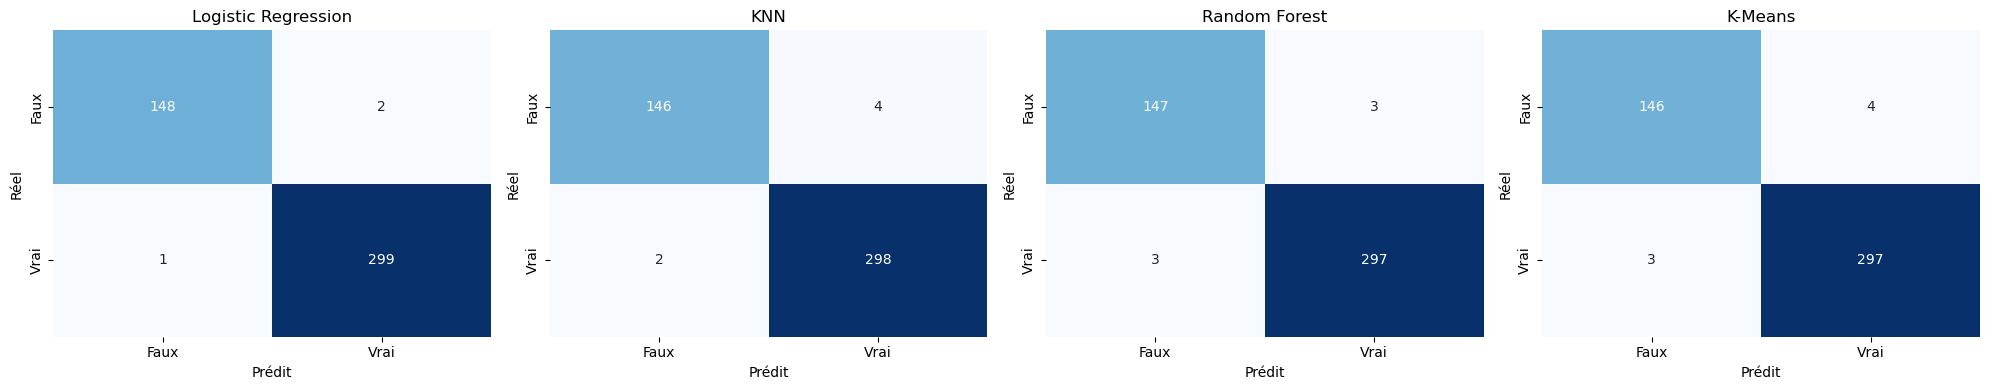

In [21]:
# Matrices de confusion côte à côte
from sklearn.metrics import confusion_matrix
models = {
    'Logistic Regression': y_pred_lr,
    'KNN': y_pred_knn,
    'Random Forest': y_pred_rf,
    'K-Means': y_pred_km
}

fig, axes = plt.subplots(1, len(models), figsize=(20,4))
for ax, (name, y_pred) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                ax=ax, xticklabels=['Faux', 'Vrai'], yticklabels=['Faux', 'Vrai'])
    ax.set_title(name)
    ax.set_xlabel('Prédit')
    ax.set_ylabel('Réel')

plt.tight_layout()
plt.show()

### 9.2 Comparaison des métriques


Tableau récapitulatif des métriques (classe 'Faux'):


,Modèle,Accuracy,Precision (Faux),Recall (Faux),F1 (Faux),Faux Positifs,Faux Négatifs
0,Logistic Regression,0.9933,0.9933,0.9867,0.9900,1,2
1,KNN,0.9867,0.9865,0.9733,0.9799,2,4
2,Random Forest,0.9867,0.9800,0.9800,0.9800,3,3
3,K-Means,0.9844,0.9799,0.9733,0.9766,3,4


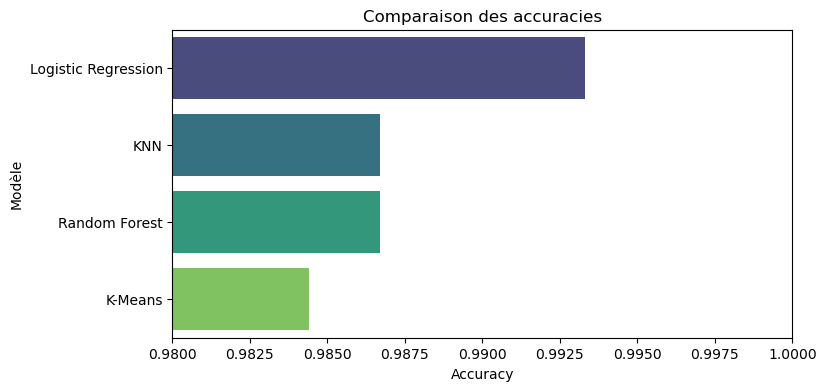

In [23]:
# Comparaison des performances
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

rows = []
for name, y_pred in models.items():
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=0)
    rec = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    faux_pos = int(cm[1,0])  # vrais (1) prédits faux (0)
    faux_neg = int(cm[0,1])  # faux (0) prédits vrais (1)

    rows.append({
        'Modèle': name,
        'Accuracy': acc,
        'Precision (Faux)': prec,
        'Recall (Faux)': rec,
        'F1 (Faux)': f1,
        'Faux Positifs': faux_pos,
        'Faux Négatifs': faux_neg
    })

recap_df = pd.DataFrame(rows)
recap_df[['Accuracy', 'Precision (Faux)', 'Recall (Faux)', 'F1 (Faux)']] = recap_df[['Accuracy', 'Precision (Faux)', 'Recall (Faux)', 'F1 (Faux)']].round(4)

print("Tableau récapitulatif des métriques (classe 'Faux'):")
display(recap_df)

# Optionnel : visualisation rapide des accurracies
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=recap_df, x='Accuracy', y='Modèle', palette='viridis', ax=ax)
ax.set_xlim(0.98, 1.0)
ax.set_title('Comparaison des accuracies')
plt.show()

### 9.3 Tableau récapitulatif


In [20]:
# Tableau récapitulatif
recap = pd.DataFrame({
    'Modèle': ['Logistic Regression', 'KNN', 'Random Forest', 'K-Means'],
    'Accuracy': [0.9933, 0.9867, 0.9867, 0.9844],
    'Precision (Faux)': [0.9933, 0.9865, 0.98, 0.9799],
    'Recall (Faux)': [0.9867, 0.9733, 0.98, 0.9733],
    'F1 (Faux)': [0.99, 0.9799, 0.98, 0.9766],
    'Faux Positifs': [1, 2, 3, 3],
    'Faux Négatifs': [2, 4, 3, 4]
})
recap


,Modèle,Accuracy,Precision (Faux),Recall (Faux),F1 (Faux),Faux Positifs,Faux Négatifs
0,Logistic Regression,0.9933,0.9933,0.9867,0.9900,1,2
1,KNN,0.9867,0.9865,0.9733,0.9799,2,4
2,Random Forest,0.9867,0.9800,0.9800,0.9800,3,3
3,K-Means,0.9844,0.9799,0.9733,0.9766,3,4


## 10. Conclusion et choix du modèle

### Résultats
Les 4 modèles testés atteignent tous une accuracy supérieure à **98.4%**, ce qui confirme
que les caractéristiques géométriques sont très discriminantes pour cette tâche.

### Choix : Régression Logistique
La **régression logistique** est choisie comme modèle final pour plusieurs raisons :
- **Meilleure accuracy** : 99.33% (1 seul faux positif, 2 faux négatifs)
- **Meilleur F1-Score** sur la classe « Faux billet » : 0.99
- **Interprétabilité** : les coefficients permettent de comprendre l'impact de chaque variable
- **Vitesse** : très rapide à entraîner et à déployer en production
- **Probabilités fiables** : les scores de confiance sont très proches de 0 ou 1

### Variables clés
D'après l'analyse (Feature Importance du Random Forest, scatter plots et distributions) :
- `margin_low` et `length` sont les deux caractéristiques les plus discriminantes
- `margin_up` et `height_left` contribuent également de façon significative

Le script d'application finale utilise ce modèle pour la prédiction en production.
